In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn import linear_model
from sklearn import ensemble
from sklearn import grid_search


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option("display.max_colwidth", 50)
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 200)


In [3]:
random_state = 1234
np.random.seed(random_state)

data_dir = 'C:/Users/eiichi/Desktop/data_analysis/The 3rd Big Data Analysis Contest'

In [4]:
# 各データ期間のタイムスタンプを作成
test_rng = pd.date_range("201601010000", "201703312330", freq="30T")  # 評価期間：30分間隔
train_rng = pd.date_range("201201010000", "201512312330", freq="30T")

In [5]:
total_rng_10 = pd.date_range("201201010000", "201703312355", freq="10T")
total_rng_10_1_day_ago = pd.date_range("201201020000", "201704012355", freq="10T")
test_rng_10 = pd.date_range("201601010000", "201703312355", freq="10T")
train_rng_10 = pd.date_range("201201010000", "201512312355", freq="10T")

In [6]:
target_list = [
#    {
#        "sfc_place": "yokohama", 
#        "sfc_id":'47670',
#        "forecast_place": "kanagawa"
#    },
    {
        "sfc_place": "tokyo", 
        "sfc_id":'47662',
        "forecast_place": "kanagawa"
    },
    {
        "sfc_place": "kouhu",
        "sfc_id":'47638',
        "forecast_place": "yamanashi"
    },
]


In [7]:
sfc_list = []
for place in [e["sfc_id"] for e in target_list]:
    sfc = pd.read_table(data_dir + "/sfc1/sfc_" + place + ".tsv", sep="\t", index_col=0)
    sfc.index = total_rng_10
    sfc.drop(sfc.columns[sfc.columns.str.startswith("f_")], axis = 1, inplace = True)
    sfc_list.append(sfc)


In [8]:
forecast_list = []
for place in [e["forecast_place"] for e in target_list]:
    forecast = pd.read_table(data_dir + "/forecast/forecast_" + place + ".tsv", sep="\t", index_col=0, parse_dates=True)  # 神奈川
    
    min_tp = pd.Series.repeat(forecast["min_tp"], 144)
    max_tp = pd.Series.repeat(forecast["max_tp"], 144)

    pc = forecast.loc[:, forecast.columns.str.startswith("pc_")]
    pc = pc.values.flatten()
    pc = np.repeat(pc, 36)
    we = forecast.loc[:, forecast.columns.str.startswith("we_")]
    we = we.values.flatten()
    we = np.repeat(we, 18)
    wv = forecast.loc[:, forecast.columns.str.startswith("wv_")]
    wv = wv.values.flatten()
    wv = np.repeat(wv, 18)
    wc = forecast.loc[:, forecast.columns.str.startswith("wc_")]
    wc = wc.values.flatten()
    wc = np.repeat(wc, 18)
    tp = forecast.loc[:, forecast.columns.str.startswith("tp_")]
    tp = tp.values.flatten()
    tp = np.repeat(tp, 18)
    df_tmp = pd.DataFrame(
        {
            "pc":pc,
            "tp":tp,
            "max_tp_day": max_tp.values,
            "min_tp_day": min_tp.values
        },
        dtype="float",
        index=total_rng_10
    )

    df_tmp_2 = pd.DataFrame(
        {
            "we":we,
            "wv":wv,
            "wc":wc,
        },
        dtype="category",
        index=total_rng_10
    )

    forecast_df = pd.concat(
        [
            df_tmp,
            df_tmp_2
        ],
        axis = 1
    )
    
    forecast_list.append(forecast_df)
    

<div style="color:red;">
学習に使えるデータは<br/>
予報は、当日<br/>
他は、前日の20:00以前<br/>

</div>

<h2>データの前処理</h2>

In [9]:
drop_col_names = set()
fill_col_names = set()

In [10]:
sfc_list[0].columns

Index(['pr', 'max_iws', 'ave_wv', 'ave_ws', 'max_tp', 'min_tp', 'sl', 'dsr',
       'gsr', 'sd', 'dsd', 'lap', 'sap', 'cap', '3h_cap', 'rhm', 'min_rhm',
       'vp', 'dtp', 'vb', 'weather'],
      dtype='object')

In [11]:
drop_col_name_list = ["dsr", "dsd", "vb", "weather"]
for sfc in sfc_list:
    sfc.drop(drop_col_name_list, axis = 1, inplace = True)
 

In [12]:
fill_col_names.add("sd")
fill_col_names.add("dsd")

In [13]:
sfc_category_name_list = ["ave_wv", "cap"]
sfc_dummy_list = []
for sfc in sfc_list:
    for col_name in sfc_category_name_list:
        s = sfc[col_name]
        sfc[col_name] = s.astype('category')
        
    # Trueにするのは、多重共線性が問題となる重回帰分析のとき
    sfc_dummy = pd.get_dummies(sfc[sfc_category_name_list], drop_first = False)
    sfc_dummy_list.append(sfc_dummy)
    

In [14]:
forcast_category_name_list = ["we", "wv", "wc"]
forcast_dummy_list = []

for forcast in forecast_list:
    for col_name in forcast_category_name_list:
        s = forcast[col_name]
        forcast[col_name] = s.astype('category')

    # Trueにするのは、多重共線性が問題となる重回帰分析のとき
    forcast_dummy = pd.get_dummies(forcast[forcast_category_name_list], drop_first = False)
    forcast_dummy_list.append(forcast_dummy)


In [15]:
# 学習＋評価期間の日時情報から月と時間の情報を抜き出しリストに格納
months = [x.month for x in total_rng_10]
hours = [x.hour for x in total_rng_10]
minutes = [x.minute for x in total_rng_10]

# 月と時間、天気情報をデータフレームに変換
dt = pd.DataFrame(
    {
        "m":months,
        "h":hours, 
        "M":minutes
    },
    dtype="category",
    index=total_rng_10
)

dt_dummy = pd.get_dummies(dt, drop_first = False)


In [16]:
train_kwh = pd.read_table(data_dir + "/train_kwh.tsv", sep="\t", index_col=0)
train_kwh.index = train_rng_10   


In [17]:
pred_list = [
    {"pred_place": "SOLA01", "index": 0, "target_index": 0, "o_name": "o_gsr"},
    {"pred_place": "SOLA02", "index": 1, "target_index": 0, "o_name": "o_gsr"},
    {"pred_place": "SOLA03", "index": 2, "target_index": 1, "o_name": "o_gsr"},
]

In [18]:
yX_list = []
for i, e in enumerate(pred_list):
    f0 = forecast_list[e["target_index"]].drop(forcast_category_name_list, axis = 1)
    f1 = forcast_dummy_list[e["target_index"]]
    f0_b3h = f0.shift(18)
    f1_b3h = f1.shift(18)
    s0 = sfc_list[e["target_index"]].drop(sfc_category_name_list, axis = 1).shift(144)
    s1 = sfc_dummy_list[e["target_index"]].shift(144)
    s2 = sfc_list[e["target_index"]][["gsr"]]
    s2.columns = pd.Index(["o_gsr"])
    t0 = train_kwh[[e["pred_place"]]]
    t0.columns = pd.Index(['o_kwh'])

    merged_f = f0.join(f1).join(f0_b3h, lsuffix = '_b3h').join(f1_b3h, lsuffix = '_b3h')
    merged_s = s0.join(s1).join(s2)
    merged = merged_f.join(merged_s).join(t0, how = 'left')
    
    yX_list.append(merged)
 


In [19]:
for yX in yX_list:
    yX.fillna({"sd": 0}, inplace = True)
    yX.fillna(yX.mean(), inplace = True)


<h2>gsrのトレーニングと推定</h2>

In [20]:
for yX in yX_list:
    yX["diff_max_tp"] = yX["max_tp_day"] - yX["tp"]
    yX["diff_min_tp"] = yX["tp"] - yX["min_tp_day"]
    yX["diff_tp_3h"] = yX["tp"] - yX["tp_b3h"]


In [21]:
yX_list_tmp = []
for yX in yX_list:
    yX_train = yX["2012-01-01":"2015-12-31"]

    gsr_stat = yX_train["o_gsr"].groupby(
        [
            yX_train.index.month,
            yX_train.index.hour,
            yX_train.index.minute,
        ]
    ).agg(['mean', 'min','max', 'median'])

    gsr_stat.columns = pd.Index(['gsr_mean', 'gsr_min','gsr_max', 'gsr_median'])
    gsr_stat

    gsr_stat["month"] = gsr_stat.index.get_level_values(0)
    gsr_stat["hour"] = gsr_stat.index.get_level_values(1)
    gsr_stat["minute"] = gsr_stat.index.get_level_values(2)

    gsr_stat

    gsr_stat_2_tmp = yX_train["o_gsr"].groupby(
        [
            yX_train.index.month,
            yX_train.index.hour,
            yX_train.index.minute,
        ]
    ).describe(percentiles = [ 0.1 * e for e in range(1, 11)])
    gsr_stat_2 = gsr_stat_2_tmp.loc[:, gsr_stat_2_tmp.columns.str.contains("%")]
    gsr_stat_2.columns = pd.Index(["gsr_" + str(e) for e in range(10, 110, 10)])

    gsr_stat_2

    gsr_stat_3 = pd.concat(
        [
            gsr_stat,
#            gsr_stat_2
        ],
        axis = 1
    )

    yX["year"] = yX.index.year
    yX["month"] = yX.index.month
    yX["day"] = yX.index.day
    yX["hour"] = yX.index.hour
    yX["minute"] = yX.index.minute

    yX_tmp = pd.merge(
        yX,
        gsr_stat_3,
        on = ["month", "hour", "minute"]
    ).sort_values(["year", "month", "day", "hour", "minute"])

    yX_tmp.index = total_rng_10
    yX_list_tmp.append(yX_tmp)

yX_list = yX_list_tmp

In [22]:
c = yX_list[0].columns
c[~c.str.startswith("o_")]

Index(['max_tp_day_b3h', 'min_tp_day_b3h', 'pc_b3h', 'tp_b3h', 'we_くもり_b3h',
       'we_晴れ_b3h', 'we_雨_b3h', 'we_雪_b3h', 'wv_北_b3h', 'wv_北東_b3h',
       ...
       'diff_tp_3h', 'year', 'month', 'day', 'hour', 'minute', 'gsr_mean',
       'gsr_min', 'gsr_max', 'gsr_median'],
      dtype='object', length=113)

In [23]:
pred_list_range = [0, 1, 2]
pred_list_filtered = [e for i, e in enumerate(pred_list) if i in pred_list_range]

In [24]:
cv_list = []
reg_list = []
for pred in pred_list_filtered:
    yX = yX_list[pred["index"]]
    
    X_col_names = yX.columns[~yX.columns.str.startswith("o_")]
    X_col_names = [
       'pc', 'tp', 'diff_tp_3h', 'we_くもり', 'we_晴れ', 'we_雨',
       'we_雪', 'wv_北', 'wv_北東', 'wv_北西', 'wv_南', 'wv_南東', 'wv_南西', 'wv_東',
       'wv_西', 'wc_1', 'wc_2', 'wc_3', 'wc_4', 'pr', 'max_iws', 'ave_ws',
       'max_tp', 'min_tp', 'sl', 'sd', 'lap', 'sap', '3h_cap', 'rhm',
       'min_rhm', 'vp', 'dtp', 'ave_wv_0.0', 'ave_wv_1.0', 'ave_wv_2.0',
       'ave_wv_3.0', 'ave_wv_4.0', 'ave_wv_5.0', 'ave_wv_6.0', 'ave_wv_7.0',
       'ave_wv_8.0', 'ave_wv_9.0', 'ave_wv_10.0', 'ave_wv_11.0', 'ave_wv_12.0',
       'ave_wv_13.0', 'ave_wv_14.0', 'ave_wv_15.0', 'ave_wv_16.0',
       'ave_wv_17.0', 'ave_wv_18.0', 'ave_wv_19.0', 'ave_wv_20.0',
       'ave_wv_21.0', 'ave_wv_22.0', 'ave_wv_23.0', 'ave_wv_24.0',
       'ave_wv_25.0', 'ave_wv_26.0', 'ave_wv_27.0', 'ave_wv_28.0',
       'ave_wv_29.0', 'ave_wv_30.0', 'ave_wv_31.0', 'ave_wv_32.0',
       'ave_wv_33.0', 'ave_wv_34.0', 'ave_wv_35.0', 'ave_wv_36.0', 'cap_0.0',
       'cap_1.0', 'cap_2.0', 'cap_3.0', 'cap_4.0', 'cap_5.0', 'cap_6.0',
       'cap_7.0', 'cap_8.0', 'gsr_min', 'gsr_max',
       'gsr_median'
    ]
    
    if pred["o_name"] == 'o_kwh':
        train_yX = yX["2012-01-01":"2014-12-31"]
        test_yX = yX["2015-01-01":"2015-12-31"]
    elif  pred["o_name"] == 'o_gsr':
        train_yX = yX["2012-01-01":"2015-12-31"]
        test_yX = yX["2016-01-01":"2017-03-31"]
    else:
        raise Exception("o_name is invalid")
    
    
    train_X = train_yX.loc[:, X_col_names]
    train_y = train_yX.loc[:, [pred["o_name"]]]
    
    test_X = test_yX.loc[:, X_col_names]
    test_y = test_yX.loc[:, [pred["o_name"]]]

    params = {
        "verbose": 2, 
        "loss": "lad", 
        "random_state": random_state
    }
    grid_params = {
        "learning_rate": [0.1],
        'max_depth': [8],
        'min_samples_split': [500],
        'min_samples_leaf':[40], 
        "n_estimators": [200],
        "max_features": ['sqrt'],
    }

    cv = grid_search.GridSearchCV(
        ensemble.GradientBoostingRegressor(
            verbose = params["verbose"], 
            loss = params["loss"], 
            random_state = params["random_state"], 
        ),
        grid_params,
        cv = 5,
        scoring='mean_absolute_error',
        verbose = 2, 
        n_jobs=2
    )
    
    cv.fit(train_X, train_y[pred["o_name"]])
    print(cv.grid_scores_)
    print(cv.best_score_ )
    print(cv.best_params_ )
    cv_list.append(cv)
    
    reg = cv.best_estimator_
    reg_list.append(reg)
    print(reg.score(train_X, train_y[pred["o_name"]]))
    print(reg.score(test_X, test_y[pred["o_name"]]))
    for f in zip(X_col_names, reg.feature_importances_ ):
        print(f)    

    


[Parallel(n_jobs=2)]: Done   6 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   5 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
      Iter       Train Loss   Remaining Time 
         1        8841.8309           26.24s
         2        8008.9484           26.53s
         3        7326.2026           27.37s
         4        6709.0205           28.44s
         5        6244.9220           27.71s
         6        5823.4434           27.58s
         7        5474.2735           26.79s
         8        5155.0851           25.95s
         9        4866.7020           24.85s
        10        4611.9901           24.11s
        11        4407.0878           24.14s
        12        4222.5090           23.72s
        13        4045.5998           23.26s
        14        3903.2770           22.63s
        15        3772.9557           21.79s
        16        3657.9425           21.45s
        17        3563.5533           20.88s
        18        3489.4993           20.29s
        19        3417.6143           19.95s
        20        3353.7549           19

[Parallel(n_jobs=2)]: Done   6 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   5 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.5min finished



      Iter       Train Loss   Remaining Time 
         1        8841.8309           27.38s
         2        8008.9484           28.01s
         3        7326.2026           29.10s
         4        6709.0205           28.79s
         5        6244.9220           28.63s
         6        5823.4434           28.31s
         7        5474.2735           27.45s
         8        5155.0851           26.58s
         9        4866.7020           25.54s
        10        4611.9901           24.72s
        11        4407.0878           24.61s
        12        4222.5090           24.11s
        13        4045.5998           23.53s
        14        3903.2770           22.78s
        15        3772.9557           21.97s
        16        3657.9425           21.60s
        17        3563.5533           20.99s
        18        3489.4993           20.29s
        19        3417.6143           19.82s
        20        3353.7549           19.26s
        21        3287.5092           18.64s
        

[Parallel(n_jobs=2)]: Done   6 out of   5 | elapsed:   57.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   5 | elapsed:   58.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   5 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.4min finished



      Iter       Train Loss   Remaining Time 
         1        9708.8985           25.24s
         2        8844.9822           24.50s
         3        8059.8280           26.09s
         4        7373.7631           26.41s
         5        6761.7005           25.65s
         6        6231.0561           25.43s
         7        5811.4903           25.36s
         8        5438.1560           24.98s
         9        5097.1891           24.69s
        10        4794.5329           24.18s
        11        4559.8524           23.70s
        12        4348.2813           23.05s
        13        4158.9161           22.71s
        14        3976.3324           22.02s
        15        3826.1622           21.54s
        16        3681.4369           21.12s
        17        3562.2745           20.44s
        18        3473.2738           19.74s
        19        3383.8384           19.23s
        20        3297.1175           18.70s
        21        3218.7402           17.98s
        

In [25]:
pred_and_actual_list = []
for pred in pred_list_filtered:
    yX = yX_list[pred["index"]]
    
    if pred["o_name"] == 'o_kwh':
        train_yX = yX["2012-01-01":"2014-12-31"]
        test_yX = yX["2015-01-01":"2015-12-31"]
    elif  pred["o_name"] == 'o_gsr':
        train_yX = yX["2012-01-01":"2015-12-31"]
        test_yX = yX["2016-01-01":"2017-03-31"]
    
    train_X = train_yX.loc[:, X_col_names]
    train_y = train_yX.loc[:, [pred["o_name"]]]
    
    test_X = test_yX.loc[:, X_col_names]
    test_y = test_yX.loc[:, [pred["o_name"]]]

    reg = reg_list[pred["index"]]
    
    predicted = reg.predict(test_X)
    predicted[predicted < 0] = 0
    
    pred_and_actual_list.append(
        {
            'pred': predicted,
            'actual': test_y[pred["o_name"]]
        }
    )
    


In [26]:
result01 = pd.DataFrame(
    {
        "pred": pred_and_actual_list[0]['pred'],
        "actual": pred_and_actual_list[0]['actual']
    }
)

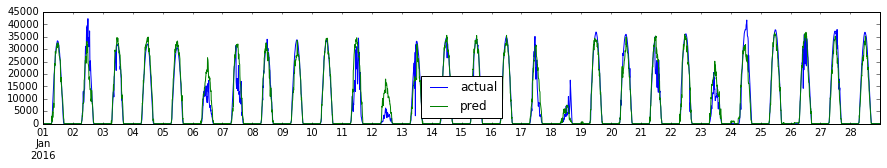

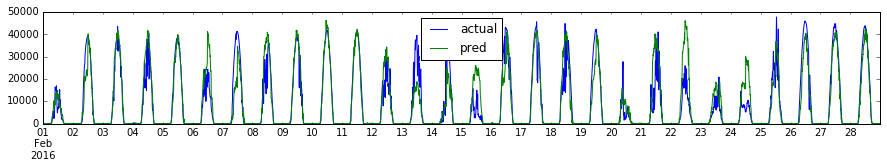

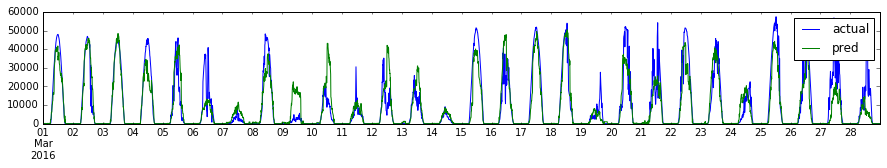

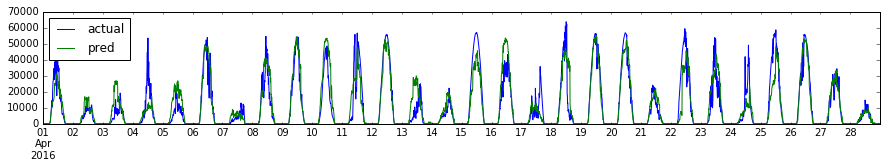

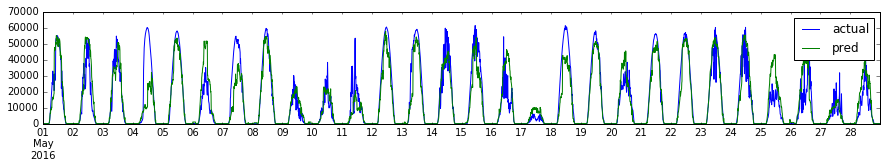

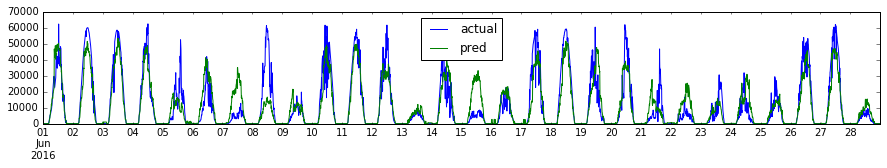

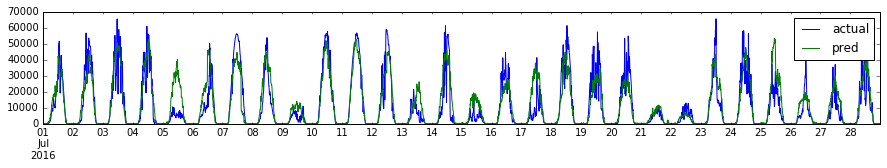

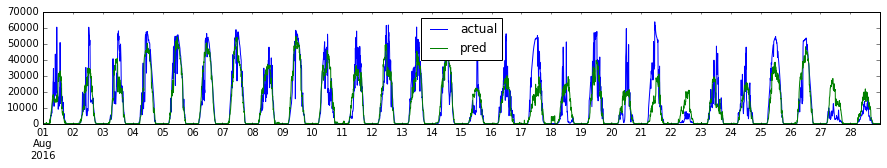

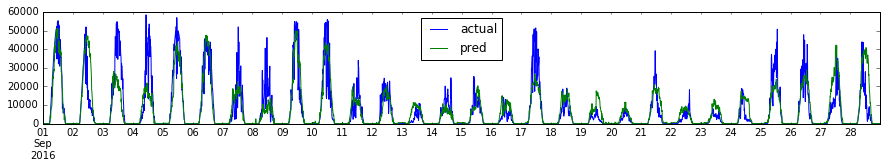

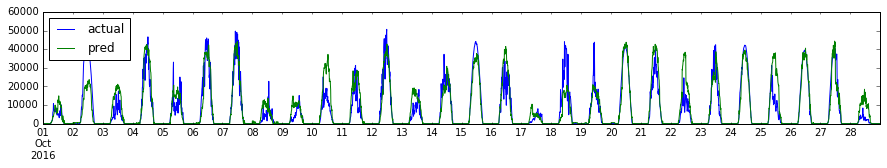

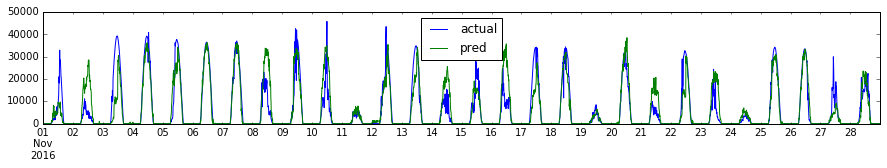

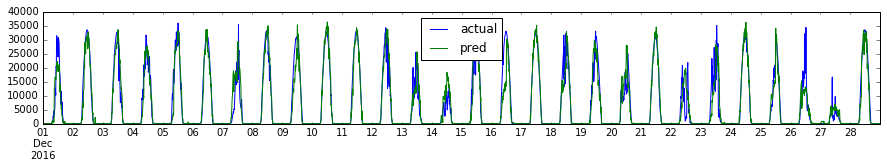

In [27]:
result01["2016-01-01":"2016-01-28"].plot(figsize=(15,2))
result01["2016-02-01":"2016-02-28"].plot(figsize=(15,2))
result01["2016-03-01":"2016-03-28"].plot(figsize=(15,2))
result01["2016-04-01":"2016-04-28"].plot(figsize=(15,2))
result01["2016-05-01":"2016-05-28"].plot(figsize=(15,2))
result01["2016-06-01":"2016-06-28"].plot(figsize=(15,2))
result01["2016-07-01":"2016-07-28"].plot(figsize=(15,2))
result01["2016-08-01":"2016-08-28"].plot(figsize=(15,2))
result01["2016-09-01":"2016-09-28"].plot(figsize=(15,2))
result01["2016-10-01":"2016-10-28"].plot(figsize=(15,2))
result01["2016-11-01":"2016-11-28"].plot(figsize=(15,2))
result01["2016-12-01":"2016-12-28"].plot(figsize=(15,2))


In [28]:
gsr_pred = pd.DataFrame(
    {
        "SOLA01":pred_and_actual_list[0]['pred'].flatten(),
        "SOLA02":pred_and_actual_list[0]['pred'].flatten(),
        "SOLA03":pred_and_actual_list[0]['pred'].flatten()
    }, 
    index=test_rng_10
)

In [29]:
gsr_pred.loc[(gsr_pred.index.hour <= 3) | (gsr_pred.index.hour >= 20)] = 0.0

In [30]:
# 学習データの読み込み
train = pd.read_table(data_dir + "/train_kwh.tsv", sep="\t", index_col=0)

# 処理しやすいように、学習データのインデックスをタイムスタンプ型に置き換える
train.index = train_rng_10


In [31]:
for pred in pred_list_filtered:
    train_y_index = train[train[pred["pred_place"]].notnull()].index
    yX = yX_list[pred["index"]]
    train_X_index = yX[yX["o_gsr"].notnull()].index
    train_index = train_y_index.intersection(train_X_index)
    
    train01_y = train.loc[train_index][pred["pred_place"]]
    


In [32]:
yX_tokyo = yX_list[0]
yX_kouhu = yX_list[2]


In [33]:
# 発電所毎に、欠損レコードを除いた発電量を抜き出し、それを学習用の目的変数とする
train01_y_index = train[train["SOLA01"].notnull()].index # 浮島発電所
train02_y_index = train[train["SOLA02"].notnull()].index # 扇島発電所
train03_y_index = train[train["SOLA03"].notnull()].index # 米倉山発電所

train01_X_index = yX_tokyo[yX_tokyo["o_gsr"].notnull()].index # 浮島発電所
train02_X_index = yX_tokyo[yX_tokyo["o_gsr"].notnull()].index # 扇島発電所
train03_X_index = yX_kouhu[yX_kouhu["o_gsr"].notnull()].index # 米倉山発電所

In [34]:
train01_index = train01_y_index.intersection(train01_X_index)
train02_index = train02_y_index.intersection(train02_X_index)
train03_index = train03_y_index.intersection(train03_X_index)

In [35]:
train01_y = train.loc[train01_index]["SOLA01"]
train02_y = train.loc[train02_index]["SOLA02"]
train03_y = train.loc[train03_index]["SOLA03"]

train01_X = yX_tokyo.loc[train01_index][["o_gsr", "max_tp"]]
train02_X = yX_tokyo.loc[train02_index][["o_gsr", "max_tp"]]
train03_X = yX_kouhu.loc[train03_index][["o_gsr", "max_tp"]]

In [36]:
# 線形回帰モデルのインスタンス作成
reg01 = ensemble.RandomForestRegressor()
reg02 = ensemble.RandomForestRegressor()
reg03 = ensemble.RandomForestRegressor()

# 学習データをフィッティング
reg01.fit(train01_X, train01_y)
reg02.fit(train02_X, train02_y)
reg03.fit(train03_X, train03_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [37]:
print(reg01.score(train01_X, train01_y))
print(reg02.score(train02_X, train02_y))
print(reg03.score(train03_X, train03_y))


0.977058587558
0.972328488875
0.982963273586


In [38]:
test01_X = pd.concat([gsr_pred[["SOLA01"]], yX_tokyo.loc["2016-01-01":"2017-03-31", ["tp"]]], axis = 1)
test02_X = pd.concat([gsr_pred[["SOLA02"]], yX_tokyo.loc["2016-01-01":"2017-03-31", ["tp"]]], axis = 1)
test03_X = pd.concat([gsr_pred[["SOLA03"]], yX_kouhu.loc["2016-01-01":"2017-03-31", ["tp"]]], axis = 1)


In [39]:
# 評価期間の発電量の予測
pred01 = reg01.predict(test01_X)
pred02 = reg02.predict(test02_X)
pred03 = reg03.predict(test03_X)

# 発電量は0以上のため、負の値は0となるよう予測値を補正
pred01[pred01 < 0] = 0
pred02[pred02 < 0] = 0
pred03[pred03 < 0] = 0

In [40]:
pred = pd.DataFrame(
    {
        "SOLA01":pred01,
        "SOLA02":pred02,
        "SOLA03":pred03
    }, 
    index=test_rng_10
)

In [41]:
pred.loc[(pred.index.hour <= 3) | (pred.index.hour >= 20)] = 0.0

In [42]:
submit = pred.groupby(pd.Grouper(freq="30T")).sum()

In [43]:
# タイムスタンプ型の日付を、応募ファイルのフォーマットに合わせて、yyyymmddhhmmの数値且つ時刻が0030-2400で表現されるよう変換
submit_rng_tmp = test_rng.strftime("%Y%m%d%H%M").astype(np.int64)
submit_rng = [x+30 if x%100==0 else x+70 for x in submit_rng_tmp]

submit.index = submit_rng

In [44]:
submit.to_csv(data_dir + "/submit.tsv", sep="\t", header=None)